# Relative Strength Index


In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from utils import get_data, get_return_simulation
from strategies import rsi

plt.style.use("seaborn")


In [2]:
PATH = "../../data/rsi.crypto.csv"
stocks = ['BTC-EUR', 'ETH-EUR', 'DOGE-EUR', 'ADA-EUR', 'SHIB-EUR']
weights = [0.4, 0.5, 0.023, 0.033, 0.043]


array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

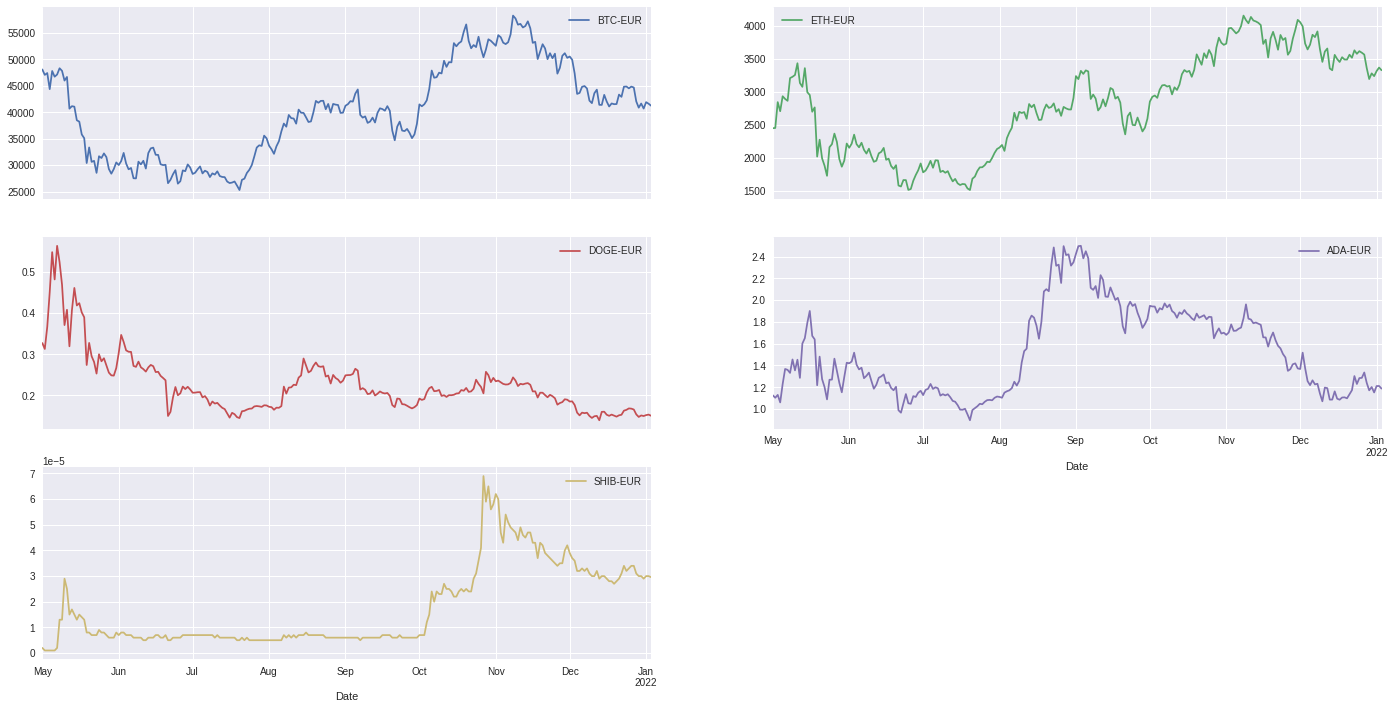

In [3]:
df = get_data(path=PATH, stocks=stocks).loc['2021-05-01':]

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))


            BTC-EUR_RSI  ETH-EUR_RSI  DOGE-EUR_RSI  ADA-EUR_RSI  SHIB-EUR_RSI  \
Date                                                                            
2021-05-01          NaN          NaN           NaN          NaN           NaN   
2021-05-02          NaN          NaN           NaN          NaN           NaN   
2021-05-03          NaN          NaN           NaN          NaN           NaN   
2021-05-04          NaN          NaN           NaN          NaN           NaN   
2021-05-05          NaN          NaN           NaN          NaN           NaN   
...                 ...          ...           ...          ...           ...   
2021-12-30    40.892990    39.628110     42.008512    46.681208     44.216598   
2021-12-31    38.149510    38.348707     41.131414    43.495640     41.887318   
2022-01-01    43.354800    42.003542     43.168695    48.020400     45.007124   
2022-01-02    42.415488    44.456136     44.299656    48.069612     45.007124   
2022-01-03    41.219422    4

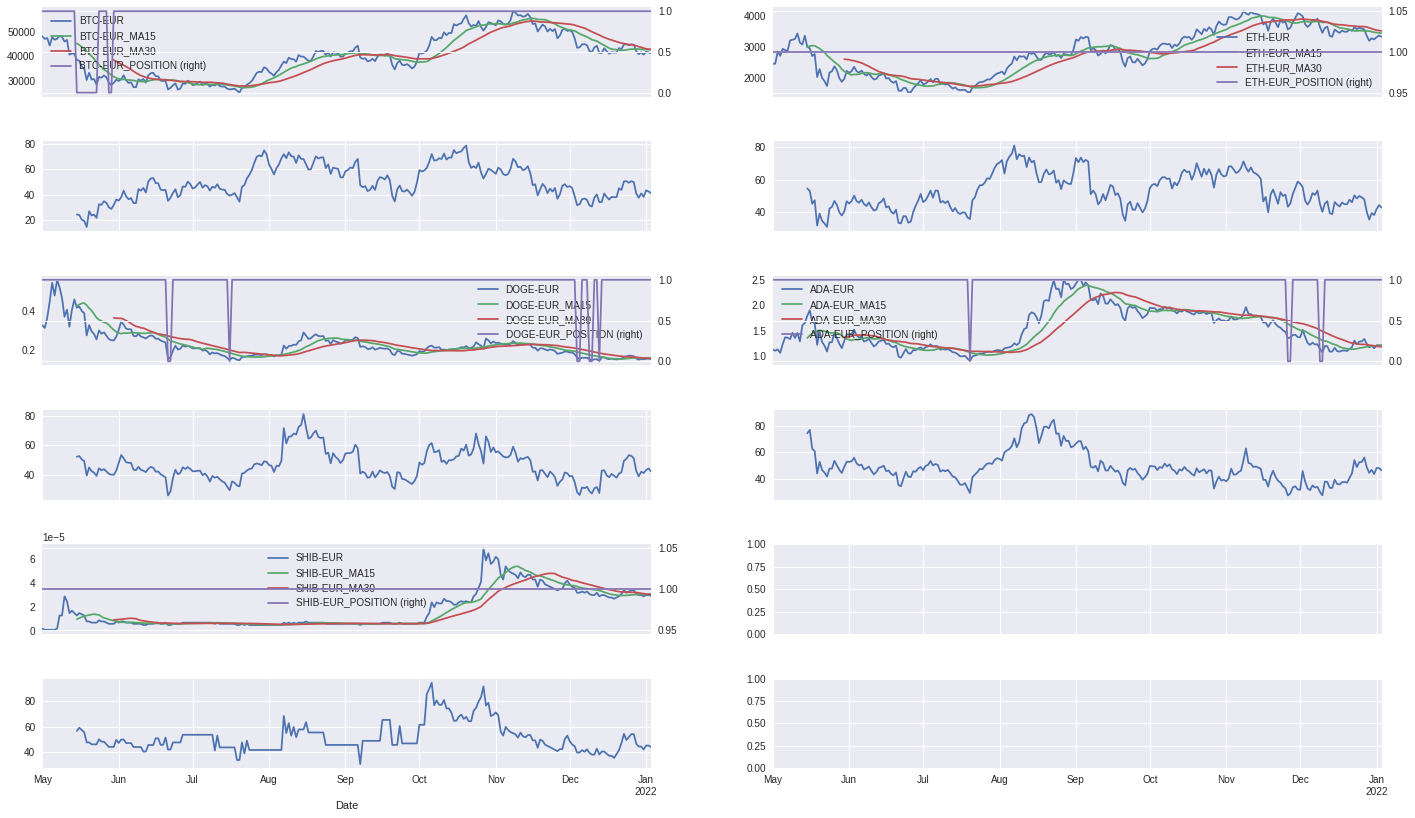

In [4]:
MA1 = 15
MA2 = 30

df = pd.concat(
    [
        df,
        df.rolling(MA1).mean().add_suffix(f"_MA{MA1}"),
        df.rolling(MA2).mean().add_suffix(f"_MA{MA2}"),
        rsi(df, stocks, periods=14),
    ],
    axis=1,
)

fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[[s, f"{s}_MA{MA1}", f"{s}_MA{MA2}", f"{s}_POSITION"]].plot(
        figsize=(24, 14), ax=axes[i // 2 * 2, i % 2], secondary_y=f"{s}_POSITION"
    )
    df[f"{s}_RSI"].plot(ax=axes[i // 2 * 2 + 1, i % 2])


## Generate buy signals


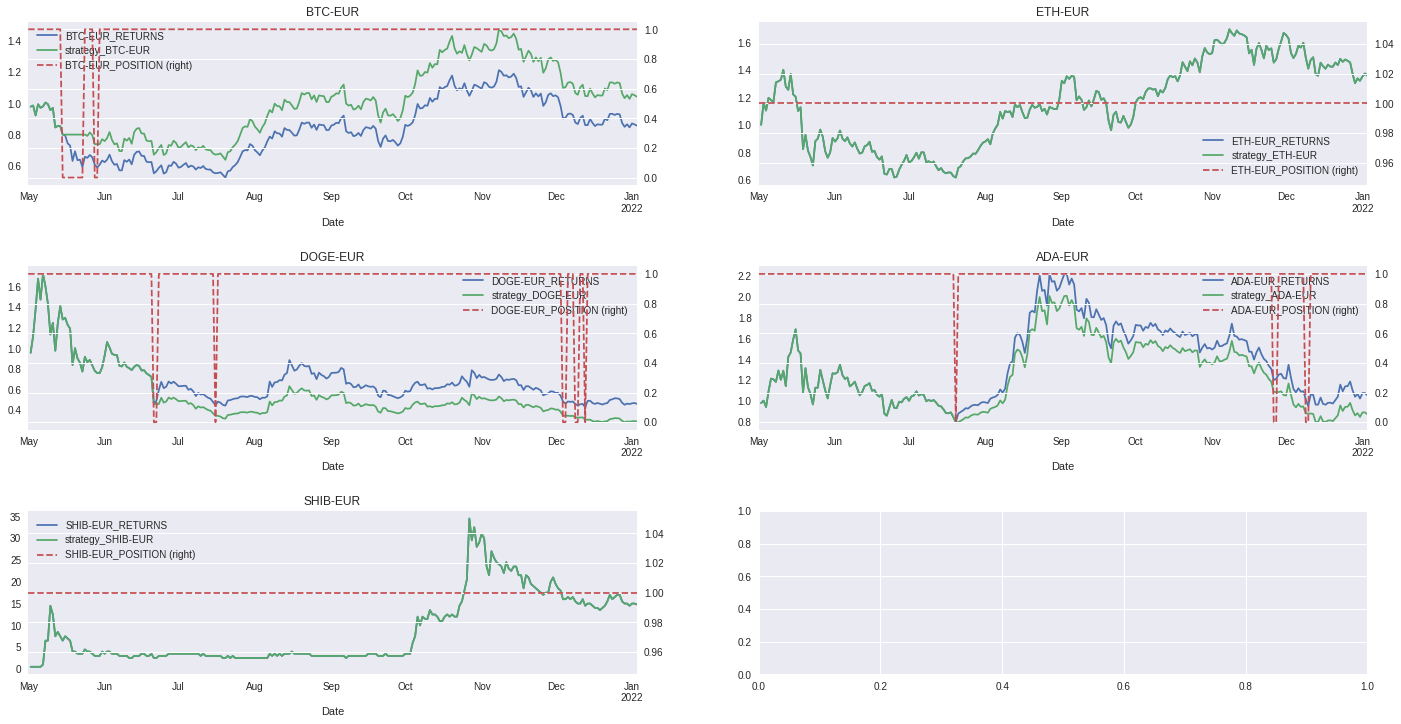

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f"{s}_RETURNS"] = np.log(df[s] / df[s].shift(1))
    df[f"strategy_{s}"] = df[f"{s}_POSITION"].shift(1) * df[f"{s}_RETURNS"]

    ax = (
        df[[f"{s}_RETURNS", f"strategy_{s}"]]
        .cumsum()
        .apply(np.exp)
        .plot(figsize=(24, 12), ax=axes[i // 2, i % 2])
    )
    df[[f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=ax, secondary_y=f"{s}_POSITION", style="--"
    )
    plt.title(s)


In [6]:
symbols = stocks[:]
results = pd.DataFrame()

data = pd.DataFrame(df[symbols])
data.dropna(inplace=True)

for rsi_periods in range(2, 16):
    t = 30
    current_df = pd.concat([data, rsi(data, symbols, rsi_periods, t)], axis=1)

    return_simulation = get_return_simulation(current_df, symbols)
    market = sum(
        [w * return_simulation[s]["base returns"] for s, w in zip(symbols, weights)]
    )
    strategy = sum(
        [w * return_simulation[s]["strategy returns"] for s, w in zip(symbols, weights)]
    )

    results = results.append(
        pd.DataFrame(
            {
                "periods": rsi_periods,
                "threshold": t,
                "market": market,
                "strategy": strategy,
                "out": strategy - market,
            },
            index=[0],
        ),
        ignore_index=True,
    )

results.info()


            BTC-EUR_RSI  ETH-EUR_RSI  DOGE-EUR_RSI  ADA-EUR_RSI  SHIB-EUR_RSI  \
Date                                                                            
2021-05-01          NaN          NaN           NaN          NaN           NaN   
2021-05-02          NaN          NaN           NaN          NaN           NaN   
2021-05-03    40.260162   100.000000     88.255878    70.016575      0.000000   
2021-05-04     4.955392    58.828365     96.888503    14.929701      0.000000   
2021-05-05    68.090729    82.514886     98.845564    82.415748      0.000000   
...                 ...          ...           ...          ...           ...   
2021-12-30    39.052658    38.667168     37.699718    39.895569      9.075320   
2021-12-31    20.479235    28.211209     29.586768    19.869767      3.752398   
2022-01-01    64.014580    63.747290     58.241005    63.396266     55.708607   
2022-01-02    50.502969    78.481650     71.069135    63.828092     55.708607   
2022-01-03    33.116831    4

In [7]:
results.sort_values("out", ascending=False).head(10)


,periods,threshold,market,strategy,out
12,14,30,1.703404,1.820215,0.116811
13,15,30,1.703404,1.817910,0.114505
10,12,30,1.703404,1.507884,-0.195521
8,10,30,1.703404,1.503705,-0.199700
11,13,30,1.703404,1.480559,-0.222846
9,11,30,1.703404,1.462522,-0.240882
7,9,30,1.703404,1.360450,-0.342954
6,8,30,1.703404,1.301226,-0.402179
4,6,30,1.703404,1.199093,-0.504312
5,7,30,1.703404,1.194069,-0.509335
